# Structural bioinformatic analysis of LiP-MS data  

This notebook provides examples for how to map peptides generated in the LiP-MS workflow to protein structures, and to compute/match different structural descriptors to the identified peptides. A prerequisite for performing the structural analysis is that you have computed a list of peptides and corresponding UniProt IDs. 

The code is written in Python (v3.7), and is dependent on the following libraries (versions used are in brackets): 

- pandas (v1.1.5)
- numpy (v1.19.4)
- Biopython (v1.78)
- seaborn (v0.11)
- matplotlib (v3.3.3)


The script provided should be considered a starting point for your own analysis and may need adaptation dependent on the questions you want to address.

#### Codeauthor: 
Fabian Sesterhenn, PhD <br/>

fabian.sesterhenn@gmail.com 


## 1) Load dependencies and dataset 

In [1]:
import re
import os
import json
import Bio.PDB
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial import distance
import gzip

from Bio.Seq import Seq
from Bio import pairwise2

from IPython.display import Javascript, display
import ipywidgets as widgets
pd.set_option("display.max_columns",100)

# Hide warnings
import warnings 
warnings.filterwarnings('ignore')
raise SystemExit("Enter the name of your data file")

SystemExit: Enter the name of your data file

In [2]:
# Load example dataset 
data = pd.read_csv("./data/LiP_corrected_short.csv")

In [3]:
# add column containing UniProtID only 
data["UPID"] = data["ProteinName"].apply(lambda x: x.split("_")[0])

In [4]:
data.head()

,Unnamed: 0,ProteinName,PeptideSequence,FULL_PEPTIDE,Label,log2FC,SE,Tvalue,DF,pvalue,adj.pvalue,fully_TRI,NSEMI_TRI,CSEMI_TRI,CTERMINUS,StartPos,EndPos,UPID
0,0,A5A614_QVAESTPDIPK,QVAESTPDIPK,A5A614_QVAESTPDIPK,IPTG_1_ vs IPTG_2_,0.818973,0.479762,1.707041,19.859925,0.103402,0.870722,False,False,False,NaN,NaN,NaN,A5A614
1,28,P00350_AASEEYNWDLNYGEIAK,AASEEYNWDLNYGEIAK,P00350_AASEEYNWDLNYGEIAK,IPTG_1_ vs IPTG_2_,0.162792,0.236313,0.688882,27.944901,0.496578,0.978035,False,False,False,NaN,NaN,NaN,P00350
2,56,P00350_AAVLPANLIQ,AAVLPANLIQ,P00350_AAVLPANLIQ,IPTG_1_ vs IPTG_2_,-0.434285,0.274801,-1.580362,25.781633,0.126216,0.872957,False,False,False,NaN,NaN,NaN,P00350
3,84,P00350_AAVLPANLIQAQ,AAVLPANLIQAQ,P00350_AAVLPANLIQAQ,IPTG_1_ vs IPTG_2_,-0.674202,0.344293,-1.958220,21.500542,0.063305,0.827714,False,False,False,NaN,NaN,NaN,P00350
4,112,P00350_AAVLPANLIQAQR,AAVLPANLIQAQR,P00350_AAVLPANLIQAQR,IPTG_1_ vs IPTG_2_,-0.611336,1.005592,-0.607936,10.543840,0.556098,0.980602,False,False,False,NaN,NaN,NaN,P00350


In [5]:
raise SystemExit("Enter the name of the columns")

SystemExit: Enter the name of the columns

## Indicate column names: 

In [6]:
# indicate column names of peptide, UniProtID, and the column containing a pvalue/adjusted pvalue. Make sure you only have proteotypic peptides. 
pep = "PeptideSequence"
UPID = "UPID"
significance = "adj.pvalue"
pvalue_cutoff = 0.05

# Filter dataframe to selected columns
df = data[[UPID,pep,significance]]


# Choose significance threshold for plotting 

df["significant"] = df[significance].apply(lambda x: True if x<pvalue_cutoff else False)


## 2) Load structural descriptors and match them to the peptides of interest

The structural descriptors used here have been computed and published by [Zhao et al., 2021](https://doi.org/10.1093/nar/gkaa931). Structural descriptors for 83 proteomes can be accessed [here](http://biomine.cs.vcu.edu/servers/DESCRIBEPROT/) and are available for download. Here, we provide pre-processed files containing secondary structure predictions (PSIPRED) and disorder predictions (VSL2B) based on the data deposited in DESCRIBEPROT. The provided files are in json format and contain python dictionaries, with keys being UniProt IDs and the values being either sequence, secondary structure prediction or disorder propensity.  

Files are provided for four organisms: 
- human
- mouse
- yeast (S. cerevisiae)
- E.coli 

Here, we are working with an E.coli dataset - so load the descriptors for E.coli: 

In [7]:
w = widgets.Dropdown(
    options=['human', 'Scerevisiae', 'Ecoli',"mouse"],
    disabled=False)
w

Dropdown(options=('human', 'Scerevisiae', 'Ecoli', 'mouse'), value='human')

In [8]:
def run_all(ev):
    display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, IPython.notebook.ncells())'))

button = widgets.Button(description="Run script")
button.on_click(run_all)
display(button)

Button(description='Run script', style=ButtonStyle())

<IPython.core.display.Javascript object>

In [9]:
path = "./data/"+w.value+"/"

In [10]:
path

'./data/Ecoli/'

In [11]:
# Sequence
with open(path+"UPseq_"+w.value+".json") as fi: 
    seq = json.load(fi)

# Secondary structure prediction
with open(path+"UPPSI_"+w.value+".json") as fi: 
    psi = json.load(fi)

# Disorder prediction
with open(path+"UPID_VSL2B_"+w.value+".json") as fi: 
    diso = json.load(fi)

# 3) Add new columns to dataframe containing predicted secondary structure content and disorder for each peptide

In [12]:
df["SEQ"] = df[UPID].map(seq)
df["PSIPRED"] = df[UPID].map(psi)

In [13]:
df.head(2)

,UPID,PeptideSequence,adj.pvalue,significant,SEQ,PSIPRED
0,A5A614,QVAESTPDIPK,0.870722,False,MSEFDAQRVAERIDIVLDILVAGDYHSAIHNLEILKAELLRQVAES...,CCHHHHHHHHHHHHHHHHHHHHCCHHHHHHHHHHHHHHHHHHHHHH...
1,P00350,AASEEYNWDLNYGEIAK,0.978035,False,MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAEN...,CCHHHCEEEEEEEECCCEEEEEECCCEEEEEEECCHHHCHHHHCCC...


In [14]:
idlist = df[UPID].to_list()
peplist = df[pep].to_list()
seqlist = df["SEQ"].to_list()

## Secondary structure 

In [15]:
def compute_ss_peptide(df,colname_ids = UPID,colname_pepseq=pep,colname_seq = "SEQ",colname_psipred = "PSIPRED"):

    pep_psi = []
    seqs = df[colname_seq].to_list()
    psi = df[colname_psipred].to_list()
    for i,x in enumerate(peplist):
        
        m = re.search(str(x),str(seqs[i]))
        if m:
            if (str(psi[i]) !="NaN" and str(psi[i]) !="nan"):
                ppsi = str(psi[i][m.start():m.end()])
                pep_psi.append(ppsi)
            else:
                pep_psi.append("X")
        else:
            pep_psi.append("X")
    df["peptide_psipred"] = pep_psi
    df["%loop_pep"] = df["peptide_psipred"].apply(lambda x: x.count("C")/len(x))
    df["%helix_pep"] = df["peptide_psipred"].apply(lambda x: x.count("H")/len(x))
    df["%beta_pep"] =df["peptide_psipred"].apply(lambda x: x.count("E")/len(x))
    
    
    return df

In [16]:
df2 = compute_ss_peptide(df)

## Disorder

In [17]:
pep_diso = {}
for i,x in enumerate(peplist):
    m = re.search(str(x),str(seqlist[i]))
    if m: 
        try:
            temp = diso[idlist[i]]
            ppsi = np.mean(temp[m.start():m.end()])
    
        except:
            ppsi = np.nan
    else:
        ppsi = np.nan
    pep_diso.update({peplist[i]:ppsi})

df2["Disorder"] = df2[pep].map(pep_diso)

## Output: Dataframe with secondary structure and disorder content for each peptide

In [18]:
df2

,UPID,PeptideSequence,adj.pvalue,significant,SEQ,PSIPRED,peptide_psipred,%loop_pep,%helix_pep,%beta_pep,Disorder
0,A5A614,QVAESTPDIPK,0.870722,False,MSEFDAQRVAERIDIVLDILVAGDYHSAIHNLEILKAELLRQVAES...,CCHHHHHHHHHHHHHHHHHHHHCCHHHHHHHHHHHHHHHHHHHHHH...,HHHHHCCCCCC,0.545455,0.454545,0.000000,0.491818
1,P00350,AASEEYNWDLNYGEIAK,0.978035,False,MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAEN...,CCHHHCEEEEEEEECCCEEEEEECCCEEEEEEECCHHHCHHHHCCC...,HHHHHHCCCCCHHHHHH,0.294118,0.705882,0.000000,0.239412
2,P00350,AAVLPANLIQ,0.872957,False,MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAEN...,CCHHHCEEEEEEEECCCEEEEEECCCEEEEEEECCHHHCHHHHCCC...,HEECCHHHHH,0.200000,0.600000,0.200000,0.162000
3,P00350,AAVLPANLIQAQ,0.827714,False,MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAEN...,CCHHHCEEEEEEEECCCEEEEEECCCEEEEEEECCHHHCHHHHCCC...,HEECCHHHHHHH,0.166667,0.666667,0.166667,0.170000
4,P00350,AAVLPANLIQAQR,0.980602,False,MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAEN...,CCHHHCEEEEEEEECCCEEEEEECCCEEEEEEECCHHHCHHHHCCC...,HEECCHHHHHHHH,0.153846,0.692308,0.153846,0.174615
...,...,...,...,...,...,...,...,...,...,...,...
24267,Q9JMR6,LLSELAYAGVPFDK,NaN,False,NaN,NaN,X,0.000000,0.000000,0.000000,NaN
24268,Q9JMR6,NIIESIR,0.998778,False,NaN,NaN,X,0.000000,0.000000,0.000000,NaN
24269,Q9JMR6,NIIESIRK,0.982061,False,NaN,NaN,X,0.000000,0.000000,0.000000,NaN
24270,Q9JMR6,NVELDTF,NaN,False,NaN,NaN,X,0.000000,0.000000,0.000000,NaN


# 4) Add a PDB structure

In [19]:
def convert_df_to_dict(df, key, value):
    '''''
    This function takes as input a dataframe and returns a dictionary of two selected columns. The values are organized as a list.
    '''''
    dic = {k: list(set(g[value].tolist())) for k,g in df.groupby(key)}
    return dic

def retrieve_pdb2(name):
    url = "https://files.rcsb.org/download/"

    cmd = "wget "+url+name

    if not os.path.isfile(name):
        print(cmd)
        os.system(cmd)

def extract_sequence_from_pdb(infile, chain):
    threetoone = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
     'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N',
     'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W',
     'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}
    pdb = open(infile,"r")
    pdb = pdb.readlines()
    sequence = []
    for line in pdb:
        if line.startswith("ATOM"):
            if line[21:22].strip() == chain:
                if line[13:16].strip() == "CA":
                    sequence.append((threetoone[line[17:20]]))

    return("".join(sequence))

def find_representative_pdb(pep_dict):
    '''''
    identifies a representative pdb structure (one, not several). Needs UPPDB dictionary preloaded. Extracts sequences on-the-fly.
    Input is a pep_dict, generated by: 'pep_dict = convert_df_to_dict(df,"Prot","Pep")'

    returns pep_pdb dictionary that has the peptide and a representative pdb structure that contains this peptide sequence. can be added to original dataframe
    by df["representative_PDB"] = df["Pep"].map(find_representative_pdb(pep_dict))
    '''''

    with open('./data/general/UPID_PDB_CHAIN.json', 'r') as fp:
        UPPDB = json.load(fp)
    pep_pdb_only = {}
    for upid,pep in pep_dict.items():
        count = 0
        try:
            pdb = UPPDB[upid]
        except KeyError:
            continue
        for p in pdb:
            if count < 1:
                p=str(p)
                name = p.split("_")[0]+".pdb"
                chain = p.split("_")[1]
                if not os.path.isfile(name):
                    retrieve_pdb2(name)
                try:
                    ss = extract_sequence_from_pdb(name,chain)
                except FileNotFoundError:
                    continue
                if ss:
                    for pe in pep:
                        if pe in ss:
                            count = 1
                            pep_pdb_only.update({pe:p})

            else:
                continue
    return pep_pdb_only

###### A new dataframe is created here with only 300 entries, to reduce runtime in this example. Needs to be adjusted if you want to run it for your entire dataset. 

In [20]:
# Executing this can take a while depending on the size of the dataframe and the number of PDB structures, as PDB structures are downloaded and then a new column is added to the dataframe with a representative PDB structure.
# Consider to reduce the size of your dataframe to only the necessary entries before starting to download. 
df3 = df2.head(300)
pep_dict = convert_df_to_dict(df3,UPID,pep)
df3["representative_PDB"] = df[pep].map(find_representative_pdb(pep_dict))

In [21]:
set(df3[UPID].to_list())

{'A5A614',
 'P00350',
 'P00363',
 'P00370',
 'P00393',
 'P00448',
 'P00452',
 'P00490',
 'P00509',
 'P00547'}

In [22]:
df3.head()

,UPID,PeptideSequence,adj.pvalue,significant,SEQ,PSIPRED,peptide_psipred,%loop_pep,%helix_pep,%beta_pep,Disorder,representative_PDB
0,A5A614,QVAESTPDIPK,0.870722,False,MSEFDAQRVAERIDIVLDILVAGDYHSAIHNLEILKAELLRQVAES...,CCHHHHHHHHHHHHHHHHHHHHCCHHHHHHHHHHHHHHHHHHHHHH...,HHHHHCCCCCC,0.545455,0.454545,0.000000,0.491818,NaN
1,P00350,AASEEYNWDLNYGEIAK,0.978035,False,MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAEN...,CCHHHCEEEEEEEECCCEEEEEECCCEEEEEEECCHHHCHHHHCCC...,HHHHHHCCCCCHHHHHH,0.294118,0.705882,0.000000,0.239412,2ZYA_B
2,P00350,AAVLPANLIQ,0.872957,False,MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAEN...,CCHHHCEEEEEEEECCCEEEEEECCCEEEEEEECCHHHCHHHHCCC...,HEECCHHHHH,0.200000,0.600000,0.200000,0.162000,2ZYA_B
3,P00350,AAVLPANLIQAQ,0.827714,False,MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAEN...,CCHHHCEEEEEEEECCCEEEEEECCCEEEEEEECCHHHCHHHHCCC...,HEECCHHHHHHH,0.166667,0.666667,0.166667,0.170000,2ZYA_B
4,P00350,AAVLPANLIQAQR,0.980602,False,MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAEN...,CCHHHCEEEEEEEECCCEEEEEECCCEEEEEEECCHHHCHHHHCCC...,HEECCHHHHHHHH,0.153846,0.692308,0.153846,0.174615,2ZYA_B


# 5) Create a list of commands to load in PyMol and visualize the identified peptides

Load dependencies

In [23]:
with open("./data/general/UPID_PDB_CHAIN.json") as fi: 
    UPPDB = json.load(fi)
with gzip.open("./data/general/PDB_CHAIN_SEQ.json.gz") as fi: 
    PDBseqs = json.load(fi)

Activate function to retrieve PDB files in pymol and color peptides according to significance

In [24]:
def get_PDBs_highlight_peptides(df=df,colname_ids = UPID,colname_pepseq=pep,colname_pvalue = significance,fetchall=False,maxlim=5,significance_cutoff=0.05):

    '''''
    input is a dataframe, the name of the column with the UniProtIDs, the peptide sequence and a column containing pvalues. Significance cutoff is 0.05 by default, and peptides with a smaller pval are colored red, all others black. 
    The fetchall option allows to retrieve all PDBs, even if the peptide of interest is not contained in the PDB structure (default=False)
    Maxlim is set to 5 by default, so that a maximum of 5 PDB structures are retrieved for each uniprot entry. 
    
    The dataframe will initially be sorted in descending order according to the significance peptide column. 
    This ensures that peptides that are significant will be colored last, and thus will not be overwritten by the color of an overlapping non-significant peptide. 
    
    The output is a file to copy/paste in pymol, containing the commands to retrieve pdb files,
    group them and highlight the peptides by color.
    This function relies on  the find_seq.py script for finding and highlighting the peptide sequence.

    '''''
    
    df = df.sort_values(by=colname_pvalue,ascending=False)
    
    query = convert_df_to_dict(df,colname_ids,colname_pepseq)

    pep_pval = convert_df_to_dict(df,colname_pepseq,colname_pvalue)
    
    log = open("error.log","w")
    output = open("pymol_commands.txt","w")
    output.write("run findseq.py"+"\n")
    output.write("bg_color white" +"\n")
    for s in query.keys():
        pdb = []
        pdb3 = []
        try:
            pdb.append(UPPDB[s])
        except KeyError:
            e1 = "no corresponding PDB for "+s
            log.write(e1+"\n")
            continue
        pdb2 = [val for sublist in pdb for val in sublist]
        if len(pdb2) == 0:
                print("length 0")
                continue
        else:
            for i,p in enumerate(pdb2[:maxlim]):
                try:
                    p = p.strip()
                    seq = PDBseqs[str(p)]
                except KeyError:
                    try:
                        pdbid = pdb2[i].split("_")[0]
                        pdbchain = pdb2[i].split("_")[1]
                        seq = extract_sequence_from_pdb(pdbid,pdbchain)
                    except:
                        continue
                command1 = "fetch " + p
                command2 = "color lightblue, " +p

                for x in query[s]:
                    pdbid = pdb2[i].split("_")[0]
                    pdbchain = pdb2[i].split("_")[1]
                    if str(x) in str(seq):
                            start = str(seq).index(x)-1
                            length = len(x)
                            end = start + length
                            

                            if pep_pval[x][0] < significance_cutoff:
                                color = "red"
                            else: 
                                color = "black"

                            find = "findseq "+x+", "+p+", "+p+"_"+x
                            coloring  = "color " +color+", "+p+"_"+x
                            pdb3.append(p)
                            print(command1+"\n")
                            print(find)
                            print(coloring+"\n")
                            print("delete "+p+"_"+x+"\n")
                            output.write(command1+"\n")
                            output.write(find+"\n"+coloring+"\n")
                            output.write("delete "+p+"_"+x+"\n")
                    else:
                            e2 = x+ " could not be found in "+pdbid
                            log.write(e2+"\n")
                            if fetchall:
                                output.write(command1+"\n")
        if fetchall:
            output.write("group "+ s+","+(" ".join(x for x in pdb2))+"\n")
            print("group "+ s+","+(" ".join(x for x in pdb2)))
        else:
            if len(pdb3)==0:
                continue
            else:
                output.write("group "+ s+","+(" ".join(x for x in pdb3))+"\n")
                print("group "+ s+","+(" ".join(x for x in pdb3)))
    log.close()
    output.close()
    return log, output

#### Call function and copy output in PyMol. Instead of copying, you can also use "run pymol_scripts/execute_commands.py". This script will execute the commands written in the file "pymol_commands.txt" line by line. 

In [25]:
get_PDBs_highlight_peptides(df3,UPID,pep,significance)

fetch 2ZYA_B

findseq ELSAEGFNFIGTGVSGGEEGALK, 2ZYA_B, 2ZYA_B_ELSAEGFNFIGTGVSGGEEGALK
color black, 2ZYA_B_ELSAEGFNFIGTGVSGGEEGALK

delete 2ZYA_B_ELSAEGFNFIGTGVSGGEEGALK

fetch 2ZYA_B

findseq NRELSAEGFNFIGTGVSGGEEGALK, 2ZYA_B, 2ZYA_B_NRELSAEGFNFIGTGVSGGEEGALK
color black, 2ZYA_B_NRELSAEGFNFIGTGVSGGEEGALK

delete 2ZYA_B_NRELSAEGFNFIGTGVSGGEEGALK

fetch 2ZYA_B

findseq IVSYAQGFSQLR, 2ZYA_B, 2ZYA_B_IVSYAQGFSQLR
color black, 2ZYA_B_IVSYAQGFSQLR

delete 2ZYA_B_IVSYAQGFSQLR

fetch 2ZYA_B

findseq YIGADGAGHYVK, 2ZYA_B, 2ZYA_B_YIGADGAGHYVK
color black, 2ZYA_B_YIGADGAGHYVK

delete 2ZYA_B_YIGADGAGHYVK

fetch 2ZYA_B

findseq NRELSAEGFNFIGT, 2ZYA_B, 2ZYA_B_NRELSAEGFNFIGT
color black, 2ZYA_B_NRELSAEGFNFIGT

delete 2ZYA_B_NRELSAEGFNFIGT

fetch 2ZYA_B

findseq GDIIIDGGNTFFQDTIRR, 2ZYA_B, 2ZYA_B_GDIIIDGGNTFFQDTIRR
color black, 2ZYA_B_GDIIIDGGNTFFQDTIRR

delete 2ZYA_B_GDIIIDGGNTFFQDTIRR

fetch 2ZYA_B

findseq VLSGPQAQPAGDKAEFIEK, 2ZYA_B, 2ZYA_B_VLSGPQAQPAGDKAEFIEK
color black, 2ZYA_B_VLSGPQAQPAGDKAEFIE

color black, 4BHT_B_QTEFAQAVR

delete 4BHT_B_QTEFAQAVR

fetch 4BHT_B

findseq AANAGGVAT, 4BHT_B, 4BHT_B_AANAGGVAT
color black, 4BHT_B_AANAGGVAT

delete 4BHT_B_AANAGGVAT

fetch 4BHT_B

findseq NQIQVNR, 4BHT_B, 4BHT_B_NQIQVNR
color black, 4BHT_B_NQIQVNR

delete 4BHT_B_NQIQVNR

fetch 4BHT_B

findseq TTLWPFLEQNPK, 4BHT_B, 4BHT_B_TTLWPFLEQNPK
color black, 4BHT_B_TTLWPFLEQNPK

delete 4BHT_B_TTLWPFLEQNPK

fetch 4BHT_B

findseq QTEFAQAVREVMTTLWPFLEQNPK, 4BHT_B, 4BHT_B_QTEFAQAVREVMTTLWPFLEQNPK
color black, 4BHT_B_QTEFAQAVREVMTTLWPFLEQNPK

delete 4BHT_B_QTEFAQAVREVMTTLWPFLEQNPK

fetch 4BHT_B

findseq GKSEGEVMR, 4BHT_B, 4BHT_B_GKSEGEVMR
color black, 4BHT_B_GKSEGEVMR

delete 4BHT_B_GKSEGEVMR

fetch 4BHT_B

findseq VADAMLAQGVI, 4BHT_B, 4BHT_B_VADAMLAQGVI
color black, 4BHT_B_VADAMLAQGVI

delete 4BHT_B_VADAMLAQGVI

fetch 4BHT_B

findseq EVGFMAGMMK, 4BHT_B, 4BHT_B_EVGFMAGMMK
color black, 4BHT_B_EVGFMAGMMK

delete 4BHT_B_EVGFMAGMMK

fetch 4BHT_B

findseq AGVLFAPGK, 4BHT_B, 4BHT_B_AGVLFAPGK
color black,


fetch 1R1R_C

findseq DALLDYQDYPIPAAK, 1R1R_C, 1R1R_C_DALLDYQDYPIPAAK
color black, 1R1R_C_DALLDYQDYPIPAAK

delete 1R1R_C_DALLDYQDYPIPAAK

fetch 1R1R_C

findseq YDNHLLEDYTEEEFK, 1R1R_C, 1R1R_C_YDNHLLEDYTEEEFK
color black, 1R1R_C_YDNHLLEDYTEEEFK

delete 1R1R_C_YDNHLLEDYTEEEFK

fetch 1R1R_C

findseq YSDGSANNLTHK, 1R1R_C, 1R1R_C_YSDGSANNLTHK
color black, 1R1R_C_YSDGSANNLTHK

delete 1R1R_C_YSDGSANNLTHK

fetch 1R1R_C

findseq DLLTAYK, 1R1R_C, 1R1R_C_DLLTAYK
color black, 1R1R_C_DLLTAYK

delete 1R1R_C_DLLTAYK

fetch 1R1R_C

findseq RFYDAVSTFK, 1R1R_C, 1R1R_C_RFYDAVSTFK
color black, 1R1R_C_RFYDAVSTFK

delete 1R1R_C_RFYDAVSTFK

fetch 1R1R_C

findseq ALGSPIR, 1R1R_C, 1R1R_C_ALGSPIR
color black, 1R1R_C_ALGSPIR

delete 1R1R_C_ALGSPIR

fetch 1R1R_C

findseq VPMQQLLK, 1R1R_C, 1R1R_C_VPMQQLLK
color black, 1R1R_C_VPMQQLLK

delete 1R1R_C_VPMQQLLK

fetch 1R1R_C

findseq FYDAVSTFK, 1R1R_C, 1R1R_C_FYDAVSTFK
color black, 1R1R_C_FYDAVSTFK

delete 1R1R_C_FYDAVSTFK

fetch 1R1R_C

findseq ISLPTPIMSGVR, 1R1R_C,

findseq QTPGGTGALR, 2QB2_A, 2QB2_A_QTPGGTGALR
color black, 2QB2_A_QTPGGTGALR

delete 2QB2_A_QTPGGTGALR

fetch 2QB2_A

findseq YSNPPAHGASVVATILSNDALR, 2QB2_A, 2QB2_A_YSNPPAHGASVVATILSNDALR
color black, 2QB2_A_YSNPPAHGASVVATILSNDALR

delete 2QB2_A_YSNPPAHGASVVATILSNDALR

fetch 2QB2_A

findseq SVVATILSNDALR, 2QB2_A, 2QB2_A_SVVATILSNDALR
color black, 2QB2_A_SVVATILSNDALR

delete 2QB2_A_SVVATILSNDALR

fetch 2QB2_A

findseq ANYSNPPAHGASVVATIL, 2QB2_A, 2QB2_A_ANYSNPPAHGASVVATIL
color black, 2QB2_A_ANYSNPPAHGASVVATIL

delete 2QB2_A_ANYSNPPAHGASVVATIL

fetch 2QB2_A

findseq QELLFGK, 2QB2_A, 2QB2_A_QELLFGK
color black, 2QB2_A_QELLFGK

delete 2QB2_A_QELLFGK

fetch 2QB2_A

findseq AFAAMHK, 2QB2_A, 2QB2_A_AFAAMHK
color black, 2QB2_A_AFAAMHK

delete 2QB2_A_AFAAMHK

fetch 2QB2_A

findseq PPAHGASVVATILSNDALR, 2QB2_A, 2QB2_A_PPAHGASVVATILSNDALR
color black, 2QB2_A_PPAHGASVVATILSNDALR

delete 2QB2_A_PPAHGASVVATILSNDALR

fetch 2QB2_A

findseq DSETVDR, 2QB2_A, 2QB2_A_DSETVDR
color black, 2QB2_A_DSETVDR

d

(<_io.TextIOWrapper name='error.log' mode='w' encoding='UTF-8'>,
 <_io.TextIOWrapper name='pymol_commands.txt' mode='w' encoding='UTF-8'>)

### Alternative: Color peptides according to significance in a selected pair of UniProtID and PDB 

In [26]:
def color_peptides_in_selected_PDB(df,UPID,PDB,colname_ids, colname_pepseq, colname_pvalue =significance, significance_cutoff=0.05):
    
    '''''
    Function to color peptides in a selected pair of UniProtID and PDB structure. Input is your dataframe that will be filtered according to the UniProt entry, 
    and sorted by the column indicating significance. 
    All peptides for this uniprot ID will be searched in the PDB you indicate (format: PDBCODE_CHAIN).
    The PDB will be loaded into pymol, colored in lightblue by default, and then peptides below the significance cutoff (to be specified, default 0.05) will be colored red, all other detected peptides are black. 
    Output is a file called "pymol_commands.txt" in the same working directory, that can be copied to pymol. Requires the findseq.py script. 
        
    '''''
    
    df2 = df[df[colname_ids]==UPID].sort_values(by=colname_pvalue,ascending=False)
    
    peps = df2[colname_pepseq].to_list()
    
    pep_pval = convert_df_to_dict(df2,colname_pepseq,colname_pvalue)
    
    pdb_name = PDB.split("_")[0]
    pdb_name2 = PDB.split("_")[0]+".pdb"
    pdb_chain = PDB.split("_")[1]

    output = open("pymol_commands.txt","w")
    output.write("run findseq.py"+"\n")
    output.write("bg_color white" +"\n")
    output.write("fetch " + pdb_name +"\n")
    output.write("color lightblue, "+pdb_name+"\n")
    
    
    for ind,p in enumerate(peps): 
        if pep_pval[p][0] < significance_cutoff:

            output.write("findseq "+p+", "+pdb_name+", seq_"+p+"\n")
            output.write("color red, "+"seq_"+p+"\n")
            output.write("delete "+"seq_"+p+"\n")
        else:
            output.write("findseq "+p+", "+pdb_name+", seq_"+p+"\n")
            output.write("color black, "+"seq_"+p+"\n")
            output.write("delete "+"seq_"+p+"\n")
            
    output.close()
    return output

In [27]:
df3.columns

Index(['UPID', 'PeptideSequence', 'adj.pvalue', 'significant', 'SEQ',
       'PSIPRED', 'peptide_psipred', '%loop_pep', '%helix_pep', '%beta_pep',
       'Disorder', 'representative_PDB'],
      dtype='object')

Call function. Output file will be written to your working directory and can be copied into PyMol to load the PDB and highlight all peptides. 

In [28]:
color_peptides_in_selected_PDB(df3,"P00350","2ZYA_B",UPID,pep,significance)

<_io.TextIOWrapper name='pymol_commands.txt' mode='w' encoding='UTF-8'>

# 6) Measure distances to known functional sites 

load dependencies - functional site annotations from UniProt (December 2020)

In [29]:
with open(path+w.value+'_bind_sites.json', 'r') as fp:
    bindingsites = json.load(fp)
with open(path+w.value+'_active_sites.json', 'r') as fp:
    activesites = json.load(fp)
with open(path+w.value+'_nucleotide_binding.json', 'r') as fp:
    nucleotidebinding = json.load(fp)
with open(path+w.value+'_metal_binding.json', 'r') as fp:
    metalbinding = json.load(fp)
with open(path+w.value+'_calcium_binding.json', 'r') as fp:
    calciumbinding = json.load(fp)

In [30]:
pep_dict = convert_df_to_dict(df3,UPID,pep)

In [31]:
data_representative_pdb = find_representative_pdb(pep_dict)

In [32]:
def append_value(dict_obj, key, value):
    '''''
    This function is useful for creating a dictionary where new values can be added and do not replace the value if the key was already in the dict.
    Use instead of dict.update()
    USAGE: append_value(dict,key,value). Can also be as dict inside a dict: append_value(pep_coord,k,{x:pep_coordinates})

    '''''
    # Check if key exist in dict or not
    if key in dict_obj:
        # Key exist in dict.
        # Check if type of value of key is list or not
        if not isinstance(dict_obj[key], list):
            # If type is not list then make it list
            dict_obj[key] = [dict_obj[key]]
        # Append the value in list
        dict_obj[key].append(value)
    else:
        # As key is not in dict,
        # so, add key-value pair
        dict_obj[key] = value
    return
        
        
def extract_coords(infile, chain):
    '''''
    Extracts Calpha coordinates from a PDB file. 
    Input: PDB and chain identifier. 
    
    '''''
    
    
    threetoone = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
     'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N',
     'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W',
     'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}

    pdb = open(infile,"r")
    chain = chain
    pdb = pdb.readlines()
    sequence = []
    coords = []

    output = {}
    for line in pdb:
        if line.startswith("ATOM"):
            if line[21:22].strip() == chain:
                if line[13:16].strip() == "CA":
                    sequence.append((threetoone[line[17:20]]))
                    xcoords=float(line[30:38].strip())
                    ycoords=float(line[39:46].strip())
                    zcoords=float(line[47:54].strip())
                    ar = np.array([xcoords,ycoords,zcoords])
                    coords.append(ar)
    seq = "".join(sequence)
    return coords

In [33]:
def extract_coordinates_peptides(pep_dict,seq=seq,data_representative_pdb=data_representative_pdb):
    '''''
    Input: dictionary with the UniProtID:[peptides]. 
    Requirements: 
    1) load UniProtID:sequence dictionary ("seq"). 
    2) Create dictionary with peptide:PDB from your dataframe ("data_representative_pdb")
    Output: dictionary containing the peptides with their coordinates as np.array (pep_coord)
    
    '''''
    pep_coord = {}
    for k, v in pep_dict.items():
        
        temp_dict = {}
        
        for x in v: 
            try:
                m = re.search(x,seq[k])
                pdb = data_representative_pdb[x]
    
                name = pdb.split("_")[0]+".pdb"
                chain = pdb.split("_")[1]

                if not os.path.isfile(name):
                    retrieve_pdb2(name)

                s  = extract_sequence_from_pdb(name,chain)


                o = re.search(x,s)
                xx = extract_coords(name,chain)
                pep_coordinates = xx[o.start():o.end()]
                temp_dict.update({x:pep_coordinates})
                pep_coord.update({k:temp_dict})
                #append_value(pep_coord,k,{x:pep_coordinates})

            except KeyError:
                continue
    return pep_coord

In [34]:
p = extract_coordinates_peptides(pep_dict)

In [35]:
df3.head()

,UPID,PeptideSequence,adj.pvalue,significant,SEQ,PSIPRED,peptide_psipred,%loop_pep,%helix_pep,%beta_pep,Disorder,representative_PDB
0,A5A614,QVAESTPDIPK,0.870722,False,MSEFDAQRVAERIDIVLDILVAGDYHSAIHNLEILKAELLRQVAES...,CCHHHHHHHHHHHHHHHHHHHHCCHHHHHHHHHHHHHHHHHHHHHH...,HHHHHCCCCCC,0.545455,0.454545,0.000000,0.491818,NaN
1,P00350,AASEEYNWDLNYGEIAK,0.978035,False,MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAEN...,CCHHHCEEEEEEEECCCEEEEEECCCEEEEEEECCHHHCHHHHCCC...,HHHHHHCCCCCHHHHHH,0.294118,0.705882,0.000000,0.239412,2ZYA_B
2,P00350,AAVLPANLIQ,0.872957,False,MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAEN...,CCHHHCEEEEEEEECCCEEEEEECCCEEEEEEECCHHHCHHHHCCC...,HEECCHHHHH,0.200000,0.600000,0.200000,0.162000,2ZYA_B
3,P00350,AAVLPANLIQAQ,0.827714,False,MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAEN...,CCHHHCEEEEEEEECCCEEEEEECCCEEEEEEECCHHHCHHHHCCC...,HEECCHHHHHHH,0.166667,0.666667,0.166667,0.170000,2ZYA_B
4,P00350,AAVLPANLIQAQR,0.980602,False,MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAEN...,CCHHHCEEEEEEEECCCEEEEEECCCEEEEEEECCHHHCHHHHCCC...,HEECCHHHHHHHH,0.153846,0.692308,0.153846,0.174615,2ZYA_B


In [36]:
def compute_distance_to_func_site(functionalsites,df,pep_coord,colname_pep =pep):
    
    '''''
    input: 
    functionalsites = dictionary with uniprot ids and a list of residues annotated as functional site (e.g. binding, active site)
    df = your dataframe  
    pep_coord = output from extract_coordinates_peptides() function
    colname_pep = name of the column that contains the peptide sequence
    
    output: 
    dictionary with peptide:minimal Calpha distance to a functionalsite (minimal distance to the closest functional site only!)
    
    '''''
       
    # 1) Create artificial peptides around the functional site (+/-3 residues) 
    
    active_site_peptides = {}
    for k,v in functionalsites.items():
        if str(v) == 'nan':
            continue
        else: 
            try: 
                seqs = seq[k]
            except KeyError:
                continue
            pept = []
            for x in v: 
                pept.append(seqs[x-3:x+3])
                active_site_peptides.update({k:pept})
    
    # 2) Extract coordinates from PDB for the functional site of interest
    
    active_site_coord = {}
    Pep_representative_PDB = convert_df_to_dict(df,colname_pep,"representative_PDB")
    for kk, v in active_site_peptides.items():
        try:
            for k in pep_dict[kk]:
                representative_pdb = Pep_representative_PDB[k][0]

                if str(representative_pdb) =="nan":
                    continue
                else:
                    name = representative_pdb.split("_")[0]+".pdb"
                    chain = representative_pdb.split("_")[1]
                    s  = extract_sequence_from_pdb(name,chain)

                    for x in v: 
                        try:
                            match = re.search(x,s)
                            match2 =  match.start()+2
                            
                            xx = extract_coords(name,chain)
                            pep_coordinates = xx[match2]
            
                            append_value(active_site_coord,kk,pep_coordinates)

                        except:
                            continue
        except KeyError:
            continue
        
    # 3) Compute minimal distance
    
    pep_min_dist_to_active_site = {}
    for k,v in pep_coord.items():

        try:
            active = active_site_coord[k]
        except:
            continue
        if str(active) == "nan":
            continue
        else:
            for kk,vv in v.items():

                temp_active = []
                for vvv in vv:

                    for a in active:
                        dist = np.linalg.norm(vvv-a)
                        temp_active.append(dist)
                    
                pep_min_dist_to_active_site.update({kk:min(temp_active)})
                
    
    return pep_min_dist_to_active_site


##### compute distance to active sites, binding sites etc and add to the dataframe df3

In [37]:
act_dist = compute_distance_to_func_site(activesites,df3,p)

In [38]:
bind_dist = compute_distance_to_func_site(bindingsites,df3,p)

In [39]:
ca_dist = compute_distance_to_func_site(calciumbinding,df3,p)
nucleotide_dist = compute_distance_to_func_site(nucleotidebinding,df3,p)
metal_dist = compute_distance_to_func_site(metalbinding,df3,p)

In [40]:
df3["distance_act_site"] = df3[pep].map(act_dist)
df3["distance_bind_site"] = df3[pep].map(bind_dist)
df3["distance_ca_binding"] = df3[pep].map(ca_dist)
df3["distance_nucleotide_binding"] = df3[pep].map(nucleotide_dist)
df3["distance_metal_binding"] = df3[pep].map(metal_dist)

In [41]:
df3[df3["representative_PDB"].notnull()].head(30)

,UPID,PeptideSequence,adj.pvalue,significant,SEQ,PSIPRED,peptide_psipred,%loop_pep,%helix_pep,%beta_pep,Disorder,representative_PDB,distance_act_site,distance_bind_site,distance_ca_binding,distance_nucleotide_binding,distance_metal_binding
1,P00350,AASEEYNWDLNYGEIAK,0.978035,False,MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAEN...,CCHHHCEEEEEEEECCCEEEEEECCCEEEEEEECCHHHCHHHHCCC...,HHHHHHCCCCCHHHHHH,0.294118,0.705882,0.000000,0.239412,2ZYA_B,10.123902,16.948891,NaN,21.167085,NaN
2,P00350,AAVLPANLIQ,0.872957,False,MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAEN...,CCHHHCEEEEEEEECCCEEEEEECCCEEEEEEECCHHHCHHHHCCC...,HEECCHHHHH,0.200000,0.600000,0.200000,0.162000,2ZYA_B,27.908916,5.142416,NaN,39.906635,NaN
3,P00350,AAVLPANLIQAQ,0.827714,False,MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAEN...,CCHHHCEEEEEEEECCCEEEEEECCCEEEEEEECCHHHCHHHHCCC...,HEECCHHHHHHH,0.166667,0.666667,0.166667,0.170000,2ZYA_B,27.908916,3.818236,NaN,39.906635,NaN
4,P00350,AAVLPANLIQAQR,0.980602,False,MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAEN...,CCHHHCEEEEEEEECCCEEEEEECCCEEEEEEECCHHHCHHHHCCC...,HEECCHHHHHHHH,0.153846,0.692308,0.153846,0.174615,2ZYA_B,27.908916,0.000000,NaN,39.906635,NaN
5,P00350,AGAGTDAAIDSLK,0.993225,False,MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAEN...,CCHHHCEEEEEEEECCCEEEEEECCCEEEEEEECCHHHCHHHHCCC...,CCCCCHHHHHHCH,0.461538,0.538462,0.000000,0.349231,2ZYA_B,12.971628,5.823493,NaN,0.000000,NaN
6,P00350,AGAGTDAAIDSLKPYLDK,0.979342,False,MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAEN...,CCHHHCEEEEEEEECCCEEEEEECCCEEEEEEECCHHHCHHHHCCC...,CCCCCHHHHHHCHHHCCC,0.500000,0.500000,0.000000,0.335556,2ZYA_B,12.971628,5.823493,NaN,0.000000,NaN
7,P00350,AGAGTDAAIDSLKPYLDKG,0.975408,False,MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAEN...,CCHHHCEEEEEEEECCCEEEEEECCCEEEEEEECCHHHCHHHHCCC...,CCCCCHHHHHHCHHHCCCC,0.526316,0.473684,0.000000,0.333684,2ZYA_B,12.971628,5.823493,NaN,0.000000,NaN
8,P00350,AQGFSQLR,0.832530,False,MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAEN...,CCHHHCEEEEEEEECCCEEEEEECCCEEEEEEECCHHHCHHHHCCC...,HHHHHHHH,0.000000,1.000000,0.000000,0.332500,2ZYA_B,10.613926,11.529595,NaN,21.737254,NaN
9,P00350,DEDGNYLVDVILDEAANK,NaN,False,MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAEN...,CCHHHCEEEEEEEECCCEEEEEECCCEEEEEEECCHHHCHHHHCCC...,CCCCCEEEEEEEHHHHHC,0.333333,0.277778,0.388889,0.292222,2ZYA_B,11.635227,0.000000,NaN,9.310597,NaN
10,P00350,DYFGAHTY,0.999816,False,MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAEN...,CCHHHCEEEEEEEECCCEEEEEECCCEEEEEEECCHHHCHHHHCCC...,HHCCCCCC,0.750000,0.250000,0.000000,0.250000,2ZYA_B,38.639863,0.000000,NaN,41.775165,NaN


UniProt entry P00350 (6-phosphogluconate dehydrogenase, decarboxylating) is an illustrative example with many peptides detected, an available PDB structure, and for which active sites, binding sites and nucleotide binding sites are annotated in UniProt. Distances for each peptide to the closest functional site are computed (see above). 

In [42]:
bindingsites["P00350"]

[102, 102, 191, 260, 287, 445, 451]

In [43]:
activesites["P00350"]

[183, 190]

In [44]:
nucleotidebinding["P00350"]

[10, 11, 12, 13, 14, 15, 33, 34, 35, 74, 75, 76]

## Compute distances manually between selected peptides or peptide/ligand

In [45]:
def extract_HETATM_ID(infile,chain):
    '''''
    This function is able to get the HETATM (except water) ID from a PDB file. It returns a dictionary with the format PDB:[NAMES OF LIGANDS].
    Input: a PDB file and the chain name. 
    Example: extract_HETATM_ID("PATH/TO/FILE/6xvf.pdb","A")
    '''''

    i = open(infile,"r")
    i = i.readlines()
    ligands = []
    ligands2 = []
    PDBLIG={}
    for line in i:
        if line.startswith("HETATM"):
            if line[17:20] != "HOH":
                ligand = line[17:20]
                ligands.append(ligand)
    ligands2 = list(set(ligands))
    PDBLIG[infile.strip("_HETATM.pdb")] = ligands2
    return PDBLIG

In [46]:
def compute_distance(PDB1, chain1, pep1, PDB2, chain2, pep2,mode="CA"):
    
    '''''
    Function to compute the distance between two peptides in either the same or different PDB files.
    Example: compute_distance("/PATH/TO/FILE/4jhw.pdb","CHAIN","PEPTIDEK","/PATH/TO/FILE/4jhw.pdb","CHAIN","PEPTIDEK",mode="CA")
    currently only works in Calpha mode. Measuring distances between all atoms will be added later. 
    
    '''''
        
    i1 = open(PDB1,"r").readlines()
    i2 = open(PDB2,"r").readlines()
    coords_pep1 = []
    coords_pep2 = []
    distances = []
    i1_seq = extract_sequence_from_pdb(PDB1, chain1)
    i2_seq = extract_sequence_from_pdb(PDB2, chain2)
    
    i1_list = []
    i2_list = []
    
    
    match1 = re.search(pep1,i1_seq)
    if match1 is None:
        raise Exception("peptide sequence "+pep1 + " was not found in "+PDB1) 
        
    
    match2 = re.search(pep2,i2_seq)
    if match2 is None:
        raise Exception("peptide sequence "+pep2 + " was not found in "+PDB2) 
    
    
    if mode=="CA":

        for line in i1: 
            if line.startswith("ATOM"):
                if line[21:22].strip() == chain1:
                    if line[13:16].strip() == "CA":
                        i1_list.append(line)
       
        for x in i1_list[match1.start():match1.end()]:

            x_coord = float(x[31:38].strip())
            y_coord = float(x[39:46].strip())
            z_coord = float(x[47:54].strip())
            ar = np.array([x_coord,y_coord,z_coord])
            coords_pep1.append(ar)


        for line in i2: 
            if line.startswith("ATOM"):
                if line[21:22].strip() == chain2:
                    if line[13:16].strip() == "CA":
                        i2_list.append(line)

        for x in i2_list[match2.start():match2.end()]:

            x_coord = float(x[31:38].strip())
            y_coord = float(x[39:46].strip())
            z_coord = float(x[47:54].strip())
            ar = np.array([x_coord,y_coord,z_coord])
            coords_pep2.append(ar)

        for c in coords_pep1:
            for c2 in coords_pep2:
                dist = np.linalg.norm(c-c2)
                distances.append(dist)
   
                
    print("Minmal distance is: "+str(min(distances))+" Å")
    
    #return min(distances)    

In [47]:
def compute_distance_HETATM(PDB1, chain1, pep1, PDB2, HETATM):
    
    '''''
    Function to compute the distance between a peptide and a ligand/HETATM. 
    Example: compute_distance("/PATH/TO/FILE/4jhw.pdb","CHAIN","PEPTIDEK","/PATH/TO/FILE/4jhw.pdb","LIGAND_ID")
    You can look up the ID of the ligand by calling the function "extract_HETATM_ID(PDBFILE,CHAIN)".
    '''''
        
    i1 = open(PDB1,"r").readlines()
    i2 = open(PDB2,"r").readlines()
    coords_pep1 = []
    coords_pep2 = []
    distances = []
    i1_seq = extract_sequence_from_pdb(PDB1, chain1)
    match1 = re.search(pep1,i1_seq)
    i1_list = []
    i2_list = []
    
    if match1 is None:
        raise Exception("peptide sequence "+pep1 + " was not found in "+PDB1) 


    for line in i1: 
        if line.startswith("ATOM"):
            if line[21:22].strip() == chain1:
                if line[13:16].strip() == "CA":
                    i1_list.append(line)

    for x in i1_list[match1.start():match1.end()]:

        x_coord = float(x[31:38].strip())
        y_coord = float(x[39:46].strip())
        z_coord = float(x[47:54].strip())
        ar = np.array([x_coord,y_coord,z_coord])
        coords_pep1.append(ar)


    for line in i2: 
        if line.startswith("HETATM"):
           
                if line[17:20].strip() == HETATM:
                        i2_list.append(line)

    for x in i2_list:

        x_coord = float(x[31:38].strip())
        y_coord = float(x[39:46].strip())
        z_coord = float(x[47:54].strip())
        ar = np.array([x_coord,y_coord,z_coord])
        coords_pep2.append(ar)

    for c in coords_pep1:
        for c2 in coords_pep2:
            dist = np.linalg.norm(c-c2)
            distances.append(dist)
   
                
    print("Minmal distance to ligand is: " + str(min(distances))+ " Å")
    
    #return min(distances) 

### Examples 

##### Distance between two peptides

In [48]:
compute_distance("./data/1FKL.pdb","A","GKQEVIR","./data/1FKL.pdb","A","KFDSSRDR",mode="CA")

Minmal distance is: 14.682309831903153 Å


##### Get ID of the bound ligands and compute distance between the ligand and a peptide

In [49]:
extract_HETATM_ID("./data/1FKL.pdb","A")

{'/data/1FKL': ['RAP']}

In [50]:
compute_distance_HETATM("./data/1FKL.pdb","A","GKQEVIR","./data/1FKL.pdb","RAP")

Minmal distance to ligand is: 3.2612485339207136 Å


# 7) Plotting structural parameters

<Figure size 432x288 with 0 Axes>

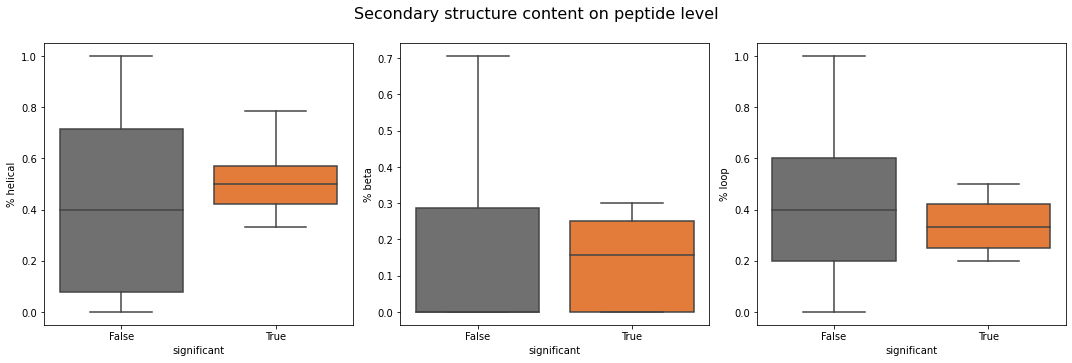

In [51]:
fig = plt.figure()
fig, ([ax1, ax2,ax3]) = plt.subplots(1,3,figsize=(15,5))

fig.suptitle(("Secondary structure content on peptide level"), y=1,fontsize=16)

sns.boxplot(y="%helix_pep", x="significant", data=df, palette=["#707070","#FF741F"],ax = ax1,showfliers=False).set_ylabel("% helical")
sns.boxplot(y="%beta_pep", x="significant", data=df, palette=["#707070","#FF741F"],ax = ax2,showfliers=False).set_ylabel("% beta")
sns.boxplot(y="%loop_pep", x="significant", data=df, palette=["#707070","#FF741F"],ax = ax3,showfliers=False).set_ylabel("% loop")

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['svg.fonttype'] = 'none'

plt.tight_layout()